# Coursework Part 2 - Vanilla DQN

Deep Q-networks are  neural networks implemented on the existing Q-learning architecture. Their utility becomes evident when working with complex environments including infinitely large state spaces, continuous spaces, etc. The code hereafter will explicitly outline the steps required to build a vanilla Q-network, with a brief look at performance with pre-selected hyperparameters. 

The environment of choice for this network is the Cartpole (v-1) task obtained from the Open AI gym. The task involves the agent balancing a pole on a cart moving along a frictionless surface. The states correspond to the following parameters: 


1.   Cart Position
2.   Cart Velocity
3.   Pole Angle
4.   Velocity at the tip of the pole

The actions available for the agent include the application of a +1 or -1 force on the cart - to move it in the right and left directions respectively. 

A reward of +1 is awarded to the agent for every time step that it can keep the pole balanced.

An episode terminates when the pole's angle is greater than 15 degrees from the vertical, or if the cart's distance from the center exceeds 2.4 units. In this case, the agent will receive a reward of 0.



In [ ]:
# Load Drive and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch 
import random
import matplotlib.pyplot as plt

## Setting up Neural Network 

The network architecture selected for the Q-network is as follows:

*   Input Layer: 4 nodes - corresponding to state dimensionality 
*   Hidden Layers: 2 layers consisting of 8 nodes
*   Output: 2 nodes - corresponding to the actions available at each state






In [ ]:
# creating network architecture
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
class DQN(nn.Module):

  def __init__(self, lr, input_dims, hidden_dims, output_dims):
    super(DQN, self).__init__()
    self.fc1 = nn.Linear(input_dims, hidden_dims)
    self.fc2 = nn.Linear(hidden_dims, hidden_dims)
    self.fc3 = nn.Linear(hidden_dims, output_dims)

    self.optimizer = optim.SGD(self.parameters(), lr=lr)
    self.criterion = nn.MSELoss()
    self.activation = nn.ReLU()

  def forward(self, x):
    h1 = self.fc1(x)
    h1_activated = self.activation(h1)
    h2 = self.fc2(h1_activated)
    h2_activated = self.activation(h2)
    output = self.fc3(h2_activated)
    return output

## Setting up Experience Replay

Experience replay involves storing transitions within an environment in a memory. Neural networks are generally constructed on independent and identically distributed data. Given the sequential nature of an agent's navigation through an environment, some tweaks will be required to ensure our i.i.d assumption holds. Whilst these changes may not guarantee the assumption completely, they offer a working solution. 

The process works by building a store of memory, consisting of an agent's transitions through an environment. A transition can be represented by the tuple (state, reward, action, next_state). Once a store of sufficient memories has been collected, the agent can randomly sample batches from this store to feed as input to the Q-network. This random/uniform sampling reduces the correlation between samples.

The "ReplayMemory" class below is constructed based on the topics discussed above. It consists of a memory capacity (the size of its memory), and the memory store itself. The methods in this class include:



*   store_transition: This method will store a transition into memory. It makes use of a private method named _convert_to_tensor which converts transitions into PyTorch tensors to facilitate compatability with the neural network architecture.
*   sample_memory: This method will sample a batch of transitions from memory and return these batches in a format compatabile for input to the neural network.



In [ ]:
class ReplayMemory():
  def __init__(self, memory_cap):
    self.memory_capacity = memory_cap
    self.memory = []
    self.current_memory_pos = 0

  def store_transition(self, state, action, reward, next_state):
    if len(self.memory) < self.memory_capacity:
      self.memory.append(None)

    state_tensor, action_tensor, reward_tensor, next_state_tensor = self._convert_to_tensor(state, action, reward, next_state)
    self.memory[self.current_memory_pos] = (state_tensor, action_tensor, reward_tensor, next_state_tensor)
    self.current_memory_pos = (self.current_memory_pos + 1) % self.memory_capacity

  def sample_memory(self, batch_size):
    memory_batch = random.sample(self.memory, batch_size)
    state_batch = []
    action_batch = []
    reward_batch = []
    next_state_batch = []

    for item in memory_batch:
      state_batch.append(item[0])
      action_batch.append(item[1])
      reward_batch.append(item[2])
      next_state_batch.append(item[3])
    
    state_batch_tensor = torch.cat(state_batch)
    action_batch_tensor = torch.cat(action_batch)
    reward_batch_tensor = torch.cat(reward_batch)
    next_state_batch_tensor = torch.cat(next_state_batch)

    return memory_batch, state_batch_tensor, action_batch_tensor, reward_batch_tensor, next_state_batch_tensor

  def _convert_to_tensor(self, state, action, reward, next_state):
    s = torch.tensor([state], dtype=torch.float, device=device)
    a = torch.tensor([[action]], device=device)
    r = torch.tensor([[reward]], device=device)
    s_new = torch.tensor([next_state], dtype=torch.float, device=device)

    return s,a,r,s_new

## Setting up Agent

The agent class below brings all the pieces together. It will be instantiated by creating an evaluation and target Q-network, as well as a memory using the classes defined above. The class architecture will also include methods to control our agent's actions and learning. All methods are shown below:

*   Epsilon_greedy_action: Implement an Epsilon greedy policy that will drive an agent's selection of actions
*   store_transition: Store a transition into memory using the ReplayMemory class explained above
*   fill_memory: Fill agent's memory upto capacity
*   sample_memory: Implement the sample_memory method from the ReplayMemory class
*   reduce_epsilon: Reduce epsilon until it reaches a minimum values specified during class instantiation
*   implement_learning: This method is where the majority of the agent's learning will take place. Batches will be drawn from memory and fed as input into the agent's Q-network defined during instantiation. It is important to note here that non-final states will not be considered for action selection - given that there are no actions available once the terminal state has been reached.

In [ ]:
class Agent():
  def __init__(self, lr, gamma, epsilon, input_dims, hidden_dims, output_dims, memory_capacity, batch_size, min_epsilon, decay):
    self.lr = lr
    self.gamma = gamma
    self.epsilon = epsilon
    self.input_dims = input_dims
    self.hidden_dims = hidden_dims
    self.output_dims = output_dims
    self.memory_capacity = memory_capacity
    self.batch_size = batch_size
    self.min_epsilon = min_epsilon
    self.decay = decay
    self.action_space = [0, 1]

    # Initialising memory
    self.memory = ReplayMemory(self.memory_capacity)

    # Initialising Q networks
    self.Qnet = DQN(lr = self.lr, input_dims = self.input_dims, hidden_dims = self.hidden_dims, output_dims = self.output_dims).to(device)
    self.Qtarget = DQN(lr = self.lr, input_dims = self.input_dims, hidden_dims = self.hidden_dims, output_dims = self.output_dims).to(device)
 
  def Epsilon_greedy_action(self, obs):
    if np.random.random() > self.epsilon:
      with torch.no_grad():
        self.Qnet.eval()  
        state = torch.tensor(obs, dtype=torch.float, device=device)
        a = self.Qnet.forward(state)
        action = torch.argmax(a).item()
        self.Qnet.train()
    else:
      action = np.random.choice(self.action_space)

    return action

  def store_transition(self, state, action, reward, nxt_state):
    self.memory.store_transition(state, action, reward, nxt_state)

  def fill_memory(self):
    memory_full = False
    _env = gym.make('CartPole-v1')
    while memory_full == False:
      obs = _env.reset()
      done = False
      while done == False:
        action = self.Epsilon_greedy_action(obs)
        nxt_obs, reward, done, info = _env.step(action) 
        if done:
          nxt_obs = [-100,-100,-100,-100]
        self.store_transition(obs, action, reward, nxt_obs)
        obs = nxt_obs
        if len(self.memory.memory) == self.memory_capacity:
          memory_full = True
    print("Memory filled")

  def sample_memory(self):
    memory_batch, state_batch_tensor, action_batch_tensor, reward_batch_tensor, next_state_batch_tensor = self.memory.sample_memory(self.batch_size)
    return state_batch_tensor, action_batch_tensor, reward_batch_tensor, next_state_batch_tensor

  def reduce_epsilon(self):
    if self.epsilon > self.min_epsilon:
      self.epsilon = self.epsilon * self.decay
    else:
      self.epsilon = self.min_epsilon

  def implement_learning(self):

    state_batch, action_batch, reward_batch, next_state_batch = self.sample_memory()
    non_final_state_b = torch.tensor(tuple(map(lambda s: s[0] != -100, next_state_batch)), device=device)
    non_final_nxt_states = next_state_batch[non_final_state_b]
    q_pred = self.Qnet.forward(state_batch).gather(1, action_batch)
    q_next = torch.zeros(self.batch_size, device=device)
    q_next[non_final_state_b] = self.Qtarget.forward(non_final_nxt_states).max(1)[0].detach()
    q_next = q_next.unsqueeze(1)
    q_target = (q_next * self.gamma) + reward_batch
    self.Qnet.optimizer.zero_grad()
    loss = self.Qnet.criterion(q_pred, q_target)
    loss.backward()

    for param in self.Qnet.parameters():
      param.grad.data.clamp_(-1,1)

    self.Qnet.optimizer.step()

    return loss

## Basic Training

The agent is now ready to begin learning. Given that the purpose of this section is to investigate the improvements to deep Q-networks, a very basic implementation will be performed below, using pre-defined hyperparameters. The results of this will be used to compare with the two improvements selected (Double DQN and Dueling DQN). Basic testing on the two improvements will also be implemented using the same pre-defined hyperparameters - with results being compared. Hyperparameter tuning will only be investigated on the improvements, which can be seen in their respective notebooks. 

The training begins instantiating the agent with the requisite hyperparameters. Its memory will first be filled and then interaction with the environment can begin. Results from these interactions will be stored as memories. After which, the implement_learning method in the agent class will be called - which will conduct training on the Q-networks created - with results being stored. 

Finally, the parameters target Q-network will be updated with the evaluation network's parameters every 20 time-steps.

In [ ]:
num_episodes = 10000
lr = 0.001
gamma = 0.9
eps = 1
input_dims = 4
hidden_dims = 8
output_dims = 2
mem_capacity = 20000
batch_size = 200
min_eps = 0.01
decay = 0.9999


agent = Agent(lr=lr, gamma=gamma, epsilon=eps, input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims, memory_capacity=mem_capacity, batch_size=batch_size,  min_epsilon=min_eps, decay=decay)
agent.Qtarget.load_state_dict(agent.Qnet.state_dict())
agent.Qtarget.eval()
agent.fill_memory()
env = gym.make('CartPole-v1')
scores = list()
for i in range(num_episodes):
  obs = env.reset()
  done = False
  score = 0
  while done == False:
    # pick an action 
    action = agent.Epsilon_greedy_action(obs)
    # interacting with environment
    nxt_obs, reward, done, info = env.step(action) 
    if done:
      nxt_obs = [-100,-100,-100,-100]
    agent.store_transition(obs, action, reward, nxt_obs)
    obs = nxt_obs
    score += reward
    l = agent.implement_learning()      
  agent.reduce_epsilon()
  scores.append(score)
  if i%20 == 0:
    agent.Qtarget.load_state_dict(agent.Qnet.state_dict())
  if i % 100 == 0:
    avg_score = np.mean(scores[-100:])
    print('episode ', i, 'avg score %.1f' % (avg_score))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Memory filled
episode  0 avg score 16.0
episode  100 avg score 22.3
episode  200 avg score 20.2
episode  300 avg score 22.4
episode  400 avg score 21.3
episode  500 avg score 21.1
episode  600 avg score 23.4
episode  700 avg score 24.6
episode  800 avg score 24.9
episode  900 avg score 28.0
episode  1000 avg score 24.8
episode  1100 avg score 26.8
episode  1200 avg score 29.4
episode  1300 avg score 31.5
episode  1400 avg score 29.2
episode  1500 avg score 28.8
episode  1600 avg score 29.8
episode  1700 avg score 31.6
episode  1800 avg score 33.7
episode  1900 avg score 32.0
episode  2000 avg score 32.9
episode  2100 avg score 35.3
episode  2200 avg score 43.4
episode  2300 avg score 40.1
episode  2400 avg score 37.7
episode  2500 avg score 38.7
episode  2600 avg score 45.9
episode  2700 avg score 44.6
episode  2800 avg score 46.2
episode  2900 avg score 43.1
episode  3000 avg score 43.5
episode  3100 avg score 51.7
episode  3200 avg score 52.7
episode  3300 avg score 45.1
episode  340

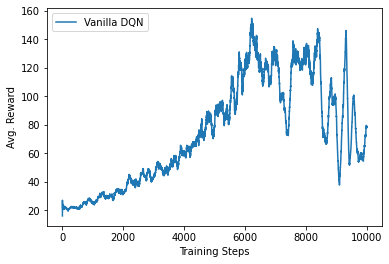

In [ ]:
# plotting results
x = [i for i in range(num_episodes)]
N = len(scores)
running_avg = np.empty(N)
for t in range(N):
  running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])
plt.plot(x, running_avg, label="Vanilla DQN")
plt.ylabel('Avg. Reward')
plt.xlabel("Training Steps")
plt.legend(loc="upper left")
plt.savefig("NaiveDQNHyperparameter.png")
plt.show() 